In [2]:
import math
import copy
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
%config IPCompleter.greedy = True
%config Completer.use_jedi = False
sns.mpl.rc('figure',figsize=(20, 6))

In [3]:
%run 8.1-forecasting-methods.ipynb

In [4]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
%matplotlib inline

In [5]:
data_load_second_interval = 5
minute_interval = 1

In [6]:
resample_second_interval = 60*15

In [7]:
resample_minutes = resample_second_interval / 60

In [8]:
hour_observations = int(60/resample_minutes)
half_hour_observations = int(hour_observations/2)
day_observations = int(60/resample_second_interval*60*24)
three_day_observations = int(60/resample_second_interval*60*24*3)
week_observations = int(60/resample_second_interval*60*24*7)

#### Load data

In [9]:
data = pd.read_csv(f"../../data/corrected_m2/corrected_data_2_{minute_interval}m_{data_load_second_interval}s.csv")
data['ndt'] = pd.to_datetime(data['ndt'])

In [10]:
data = data.groupby('ndt').sum().resample(f'{resample_second_interval}S').sum()

In [11]:
timespan_start = data.index.min()
training_timestamp = pd.date_range(start=timespan_start, end='2019-07-20 08:42:00', freq=f'{resample_second_interval}S')
training_split = len(data.loc[:training_timestamp[-1]]) #int(len(sea_data)*0.7) # 70%

In [12]:
arimax_forecasts = pd.read_csv('../../data/forecasts/total_arimax_forecasts_15.csv', index_col=0, parse_dates=True)
total_speculative = pd.read_csv('../../data/forecasts/total_hts_speculative_15.csv', index_col=0, parse_dates=True)
total_rt = pd.read_csv('../../data/forecasts/total_hts_rt_15.csv', index_col=0, parse_dates=True)
total_oracle = pd.read_csv('../../data/forecasts/total_hts_oracle_15.csv', index_col=0, parse_dates=True)

In [13]:
share_above_10 = pd.read_csv("../../data/peaks/peaks_with_temporal_share_10.csv", index_col=0)
share_above_10['ndt'] = pd.to_datetime(share_above_10['ndt'])

In [14]:
share_above_10 = share_above_10[share_above_10['ndt'] > '2019-07-20 08:45:00']

In [15]:
anomaly_free_data = data.copy()

In [16]:
pd.options.mode.chained_assignment = None 

def mean_range(data, start, end):
    past_start = pd.Timestamp(start) - pd.Timedelta(days=1)
    past_end = pd.Timestamp(end) - pd.Timedelta(days=1)
    future_start = pd.Timestamp(start) + pd.Timedelta(days=1)
    future_end = pd.Timestamp(end) + pd.Timedelta(days=1)
    new_vals = data.loc[past_start:past_end]['count'].values + data.loc[future_start:future_end]['count'].values / 2
    data.loc[start:end]['count'] = new_vals
    return data

In [17]:
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-22 12:30:00','2019-07-22 12:45:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-22 08:00:00','2019-07-22 08:00:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-22 13:45:00','2019-07-22 13:45:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-24 13:00:00','2019-07-24 13:00:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-29 12:15:00','2019-07-29 12:45:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-08-01 13:00:00','2019-08-01 14:15:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-08-02 14:15:00','2019-08-02 14:45:00')

<AxesSubplot:xlabel='ndt'>

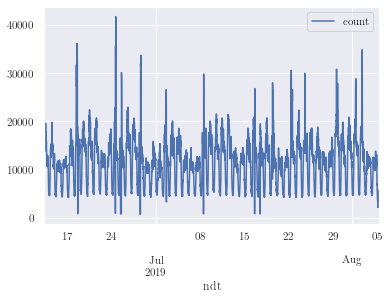

In [18]:
anomaly_free_data.plot()

In [19]:
#anomaly_free_data.to_csv(f"../../data/corrected_m2/corrected_data_2_15m_anomaly_free.csv")

In [96]:
def zoom_plot(datetime, ax):
    peak_time = datetime
    observed_start = peak_time - pd.Timedelta(minutes=180)
    observed_end = peak_time + pd.Timedelta(minutes=180)
    anomaly_free_data.loc[observed_start:observed_end + pd.Timedelta(minutes=180)].plot(ax=ax)

    for row in arimax_forecasts[observed_start:observed_end].iterrows():
        forecast_data = pd.Series(row[1].values,
                              index=pd.date_range(
                                  start=row[0] + pd.Timedelta(minutes=resample_minutes),
                                  end=row[0] + pd.Timedelta(minutes=180),
                                  freq=f'{resample_second_interval}S'))
        forecast_data.plot(ax=ax, color='r', alpha=0.5)
    
    for row in total_rt[observed_start:observed_end].iterrows():
        forecast_data = pd.Series(row[1].values,
                              index=pd.date_range(
                                  start=row[0] + pd.Timedelta(minutes=resample_minutes),
                                  end=row[0] + pd.Timedelta(minutes=180),
                                  freq=f'{resample_second_interval}S'))
        forecast_data.plot(ax=ax, color='g', alpha=0.5)
    ax.legend(['Total', 'ARIMAX', 'HTS-RT'], fontsize="x-small")
    ax.get_legend().legendHandles[1].set_color('red')
    ax.get_legend().legendHandles[2].set_color('green')
    ax.set_ylabel("")

In [97]:
def zoom_plot(forecasts, observations, datetime, ax, plot_observations=True, color=None, alpha=0.35):
    peak_time = datetime
    observed_start = peak_time - pd.Timedelta(minutes=240)
    observed_end = peak_time + pd.Timedelta(minutes=240)
    if (plot_observations):
        observations.loc[observed_start:observed_end + pd.Timedelta(minutes=45)].plot(ax=ax)
    
    resample_s = '900S'
    if(len(forecasts.columns) == 30):
        resample_s = '60S'
    
    for row in forecasts[observed_start:observed_end].iterrows():
        forecast_data = observations.loc[row[0]].append(row[1])
        forecast_data.index = index=pd.date_range(start=row[0], end=row[0] + pd.Timedelta(minutes=180), freq=resample_s)
        if color is None:
            forecast_data.plot(ax=ax, alpha=alpha)
        else:
            forecast_data.plot(ax=ax, color=color, alpha=alpha)

In [98]:
share_above_10['Total request share'].describe()

count    17.000000
mean      0.118711
std       0.015715
min       0.101667
25%       0.107449
50%       0.116105
75%       0.120614
max       0.160254
Name: Total request share, dtype: float64

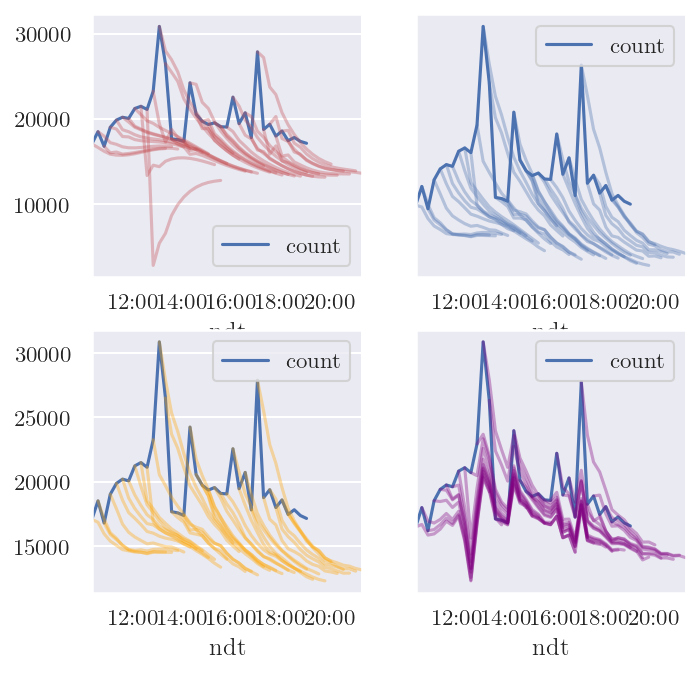

In [99]:
fig, ax = plt.subplots(2, 2, tight_layout=False, dpi=150)
fig.set_size_inches(w=5.10686, h=5.10686)

zoom_plot(arimax_forecasts, anomaly_free_data, share_above_10.iloc[0]['ndt'], ax[0][0], color='r')
zoom_plot(total_speculative, anomaly_free_data, share_above_10.iloc[0]['ndt'], ax[0][1], color='b')
zoom_plot(total_rt, anomaly_free_data, share_above_10.iloc[0]['ndt'], ax[1][0], color='orange')
zoom_plot(total_oracle, anomaly_free_data, share_above_10.iloc[0]['ndt'], ax[1][1], color='purple')
ax[0][1].set_ylabel("")
ax[1][1].set_ylabel("")
ax[1][1].get_yaxis().set_visible(False)
ax[0][1].get_yaxis().set_visible(False)
#ax[1][].set_ylabel("")
#ax[0][].set_ylabel("")

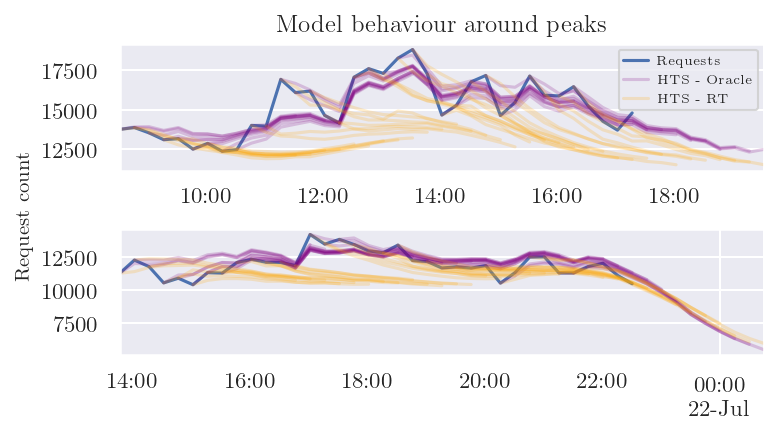

In [72]:
fig, ax = plt.subplots(2, 1, tight_layout=True, dpi=150)
fig.set_size_inches(w=5.10686, h=3)

#zoom_plot(arimax_forecasts, anomaly_free_data, share_above_10.iloc[0]['ndt'], ax[0], color='orange')
zoom_plot(total_oracle, anomaly_free_data, share_above_10.iloc[1]['ndt'], ax[0], color='purple', alpha=0.20)
zoom_plot(total_oracle, anomaly_free_data, share_above_10.iloc[14]['ndt'], ax[1], color='purple', alpha=0.20)

zoom_plot(total_rt, anomaly_free_data, share_above_10.iloc[1]['ndt'], ax[0], plot_observations=False, color='orange', alpha=0.20)
zoom_plot(total_rt, anomaly_free_data, share_above_10.iloc[14]['ndt'], ax[1], plot_observations=False, color='orange', alpha=0.20)
ax[0].set_title("Model behaviour around peaks")
ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[1].get_legend().set_visible(False)
ax[0].legend(['Requests', 'HTS - Oracle', 'HTS - RT'], fontsize="xx-small", loc='upper right')
#ax[0].get_legend().legendHandles[1].set_color('purple')
ax[0].get_legend().legendHandles[2].set_color('orange')

fig.text(0.005,0.5, 'Request count', ha="center", va="center", rotation=90)
#ax[0][1].get_yaxis().set_visible(False)
#ax[1][].set_ylabel("")
#ax[0][].set_ylabel("")
fig.savefig('../../plots/text-plots/9-15min-local-peak-example.pgf')

Text(0.005, 0.5, 'Request count')

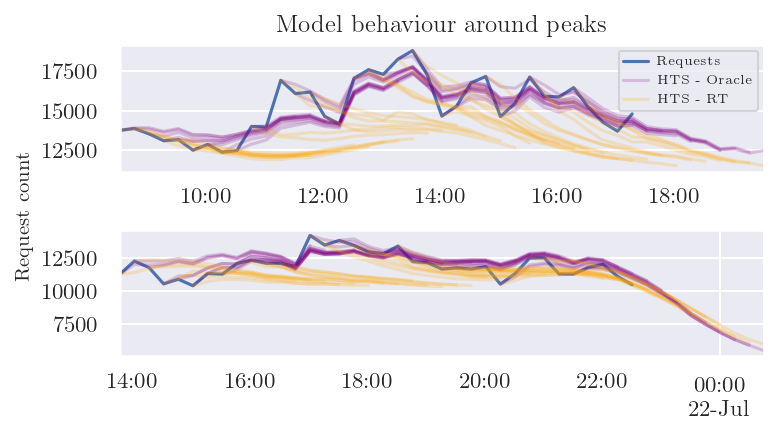

In [112]:
fig, ax = plt.subplots(2, 1, tight_layout=True, dpi=150)
fig.set_size_inches(w=5.10686, h=3)

#zoom_plot(arimax_forecasts, anomaly_free_data, share_above_10.iloc[0]['ndt'], ax[0], color='orange')
zoom_plot(total_oracle, anomaly_free_data, share_above_10.iloc[1]['ndt'], ax[0], color='purple', alpha=0.20)
zoom_plot(total_oracle, anomaly_free_data, share_above_10.iloc[14]['ndt'], ax[1], color='purple', alpha=0.20)

zoom_plot(total_rt, anomaly_free_data, share_above_10.iloc[1]['ndt'], ax[0], plot_observations=False, color='orange', alpha=0.20)
zoom_plot(total_rt, anomaly_free_data, share_above_10.iloc[14]['ndt'], ax[1], plot_observations=False, color='orange', alpha=0.20)
ax[0].set_title("Model behaviour around peaks")
ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[1].get_legend().set_visible(False)
ax[0].legend(['Requests', 'HTS - Oracle', 'HTS - RT'], fontsize="xx-small", loc='upper right')
#ax[0].get_legend().legendHandles[1].set_color('purple')
ax[0].get_legend().legendHandles[2].set_color('orange')

fig.text(0.005,0.5, 'Request count', ha="center", va="center", rotation=90)
#ax[0][1].get_yaxis().set_visible(False)
#ax[1][].set_ylabel("")
#ax[0][].set_ylabel("")
#fig.savefig('../../plots/text-plots/9-15min-local-peak-example.pgf')

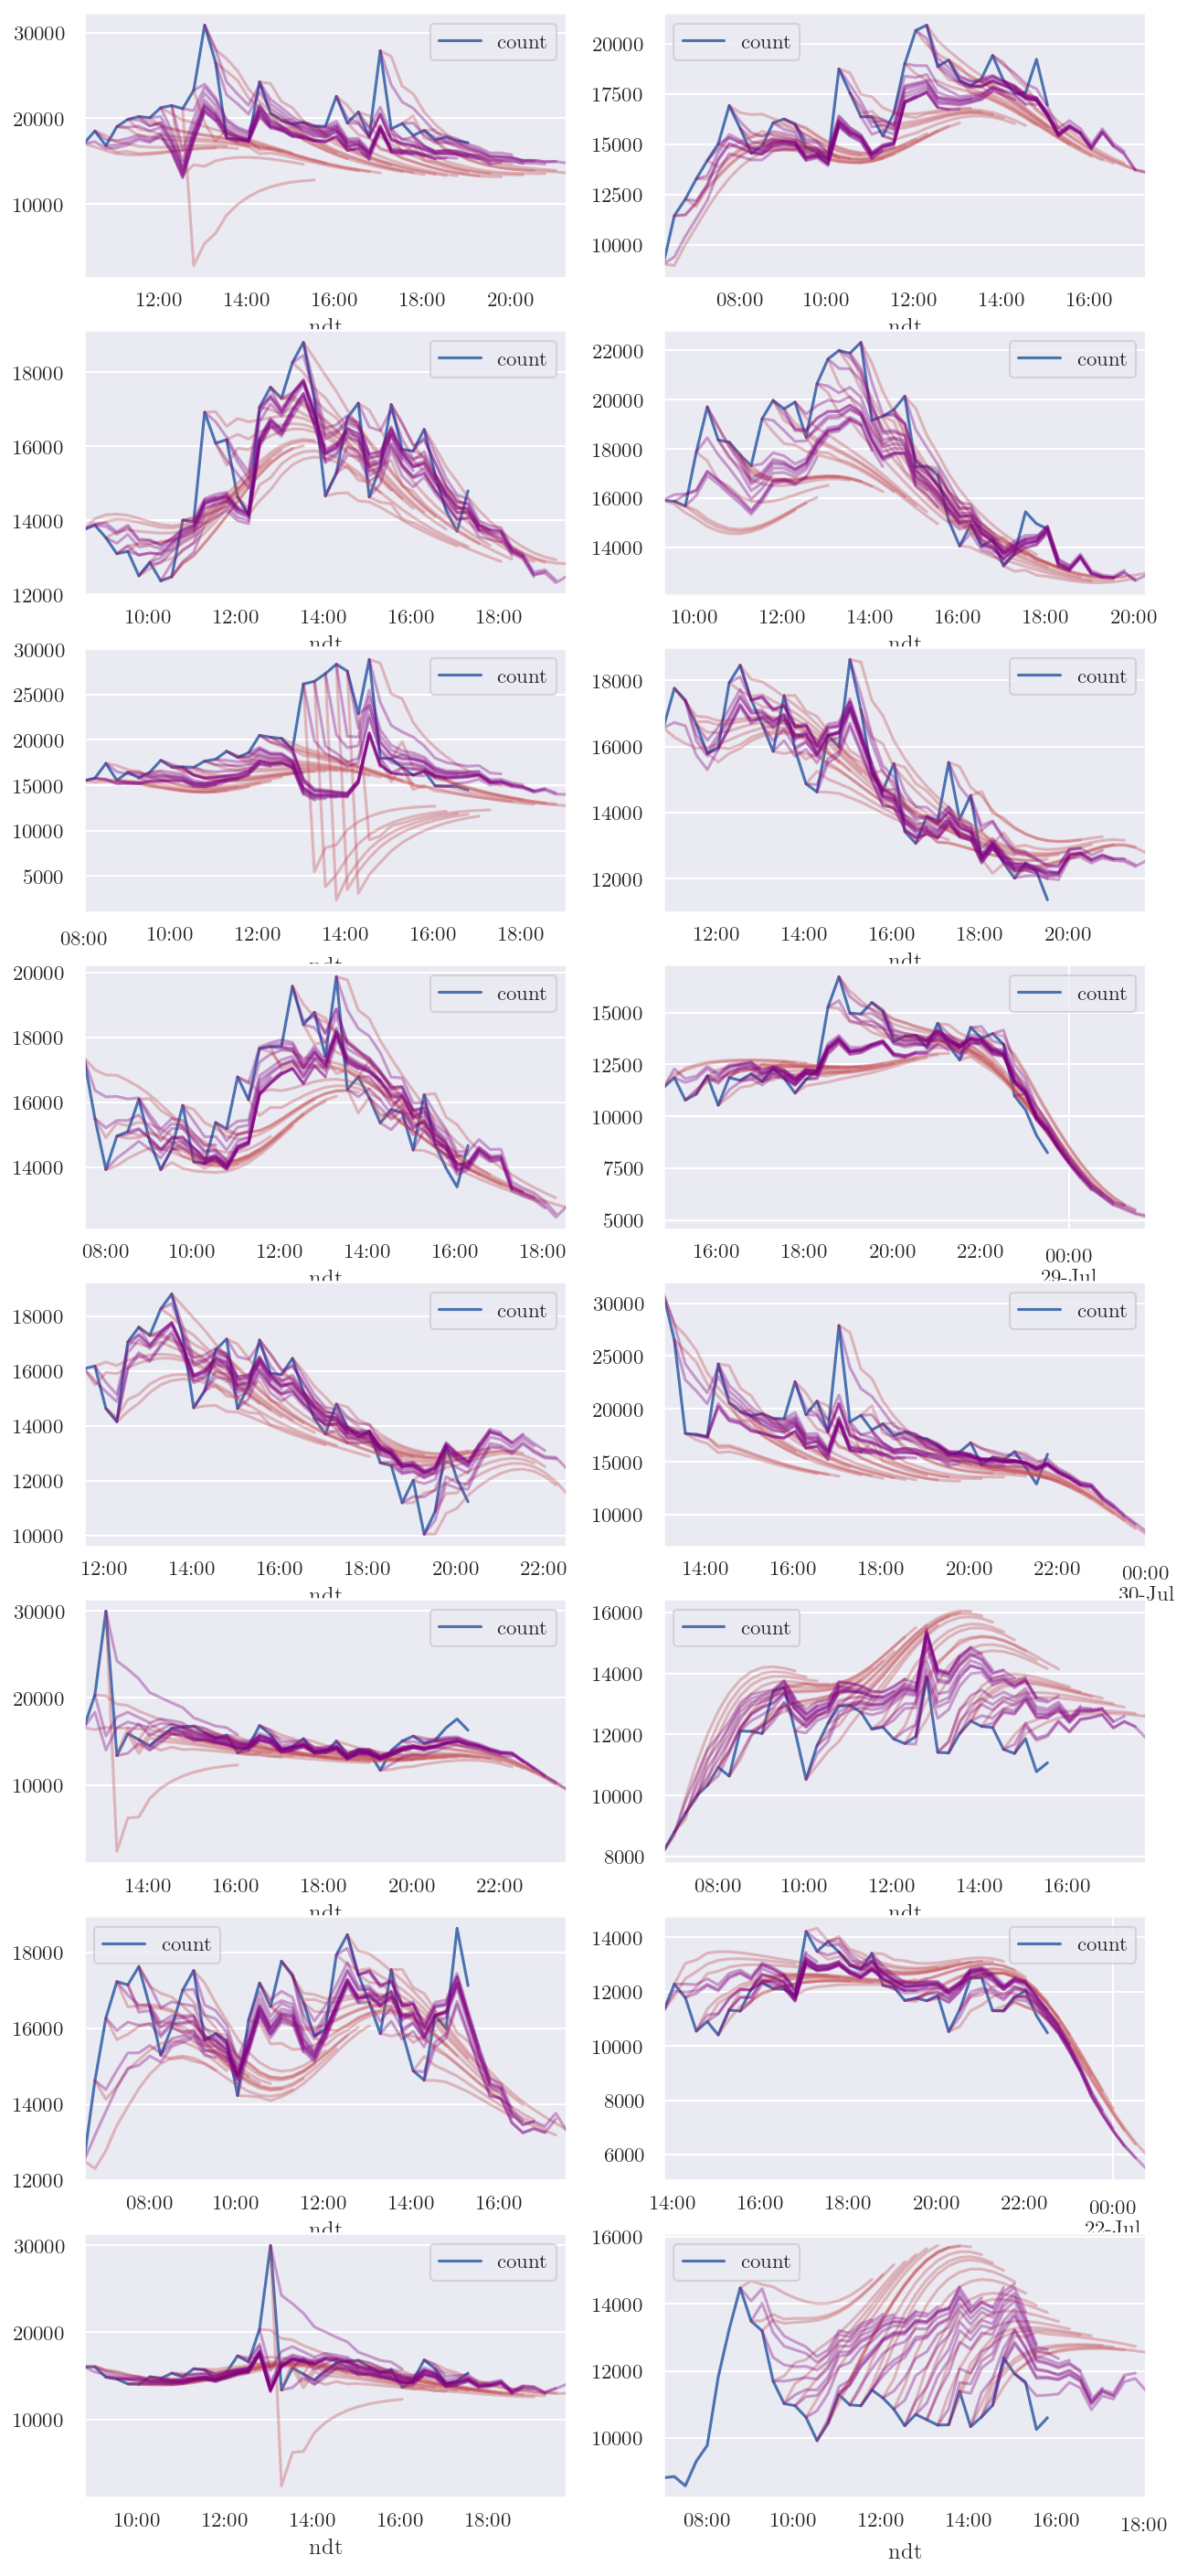

In [100]:
fig, ax = plt.subplots(8, 2, tight_layout=False, dpi=150)
fig.set_size_inches(w=10, h=24)
for i in range(0, 8):
    #zoom_plot(share_above_10.iloc[i]['ndt'], ax[i][0])
    zoom_plot(arimax_forecasts, anomaly_free_data, share_above_10.iloc[i]['ndt'], ax[i][0], color='r')
    zoom_plot(total_oracle, anomaly_free_data, share_above_10.iloc[i]['ndt'], ax[i][0], plot_observations=False, color='purple')
for i in range(0, 8):
    #zoom_plot(share_above_10.iloc[i+8]['ndt'], ax[i][1])
    zoom_plot(arimax_forecasts, anomaly_free_data, share_above_10.iloc[i+8]['ndt'], ax[i][1], color='r')
    zoom_plot(total_oracle, anomaly_free_data, share_above_10.iloc[i+8]['ndt'], ax[i][1], plot_observations=False, color='purple')

In [101]:
def local_peak_errors(data, forecasts, peaks, minutes_back = 180, minutes_forward = 180):
    errors = []
    for peak in  peaks.iterrows():
        peak_time = peak[1]['ndt']
        observed_start = peak_time - pd.Timedelta(minutes=minutes_back)
        observed_end = peak_time + pd.Timedelta(minutes=minutes_forward)
    
        for forecast_start in pd.date_range(start=observed_start, end=observed_end, freq=f"{resample_second_interval}S"):
            observed_data = data.loc[forecast_start+pd.Timedelta(minutes=15):forecast_start+pd.Timedelta(minutes=180)]
            if (forecast_start in forecasts.index):
                forecasted_data = forecasts.loc[forecast_start]
                errors.append((observed_data.values.reshape(1, -1)[0] - forecasted_data))#.reshape(-1, 1))
            
            else:
                continue
    return pd.DataFrame(errors)

In [102]:
local_hts_rt_mse, local_hts_rt_rmse = rmse_forecasts(local_peak_errors(anomaly_free_data, total_rt, share_above_10))
local_arimax_mse, local_arimax_rmse = rmse_forecasts(local_peak_errors(anomaly_free_data, arimax_forecasts, share_above_10))
local_hts_speculative_mse, local_hts_speculative_rmse = rmse_forecasts(local_peak_errors(anomaly_free_data, total_speculative, share_above_10))

In [103]:
local_arimax_rmse.sum()

1107895.97629188

In [104]:
local_hts_speculative_rmse.sum()

1212134.3064868702

In [105]:
local_hts_rt_rmse.sum()

1240383.635751556

In [106]:
peak_arima_errors = []
for row in arimax_forecasts.iterrows():
    row_timestamp = row[0]
    row_data = row[1]
    observed_data = anomaly_free_data.loc[row_timestamp+pd.Timedelta(minutes=15):row_timestamp+pd.Timedelta(minutes=180)]
    peak_arima_errors.append((observed_data.values.reshape(1, -1)[0] - row_data[:len(observed_data)].values))
peak_arima_errors= pd.DataFrame(peak_arima_errors).fillna(0)

In [107]:
peak_hts_errors = []
for row in total_rt.iterrows():
    row_timestamp = row[0]
    row_data = row[1]
    observed_data = anomaly_free_data.loc[row_timestamp+pd.Timedelta(minutes=15):row_timestamp+pd.Timedelta(minutes=180)]
    peak_hts_errors.append((observed_data.values.reshape(1, -1)[0] - row_data[:len(observed_data)].values))
peak_hts_errors= pd.DataFrame(peak_hts_errors).fillna(0)

In [108]:
def mean_forecasts(forecasts):
    columns = len(forecasts.columns) - 1
    forecast_means = []
    for i in range(columns, -(len(forecasts)-columns), -1):
        forecast_means.append(np.diag(np.fliplr(forecasts), i)[:3].mean())
    return pd.DataFrame(forecast_means, index=forecasts.index.shift(freq=f'{resample_second_interval}S'))

In [109]:
arimax_forecast_means = mean_forecasts(arimax_forecasts)
rt_forecast_means = mean_forecasts(total_rt)

<AxesSubplot:xlabel='ndt'>

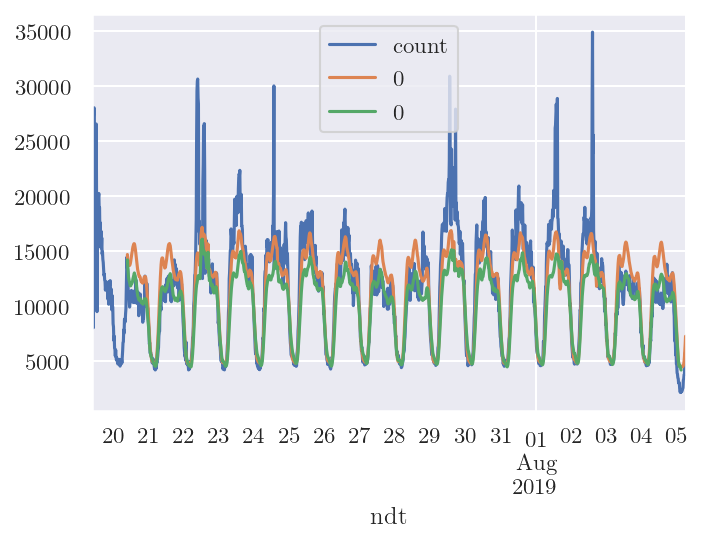

In [110]:
fig, ax = plt.subplots(1, 1, tight_layout=False, dpi=150)
fig.set_size_inches(w=5.10686, h=3.5)
anomaly_free_data[training_split-96:].plot(ax=ax)
arimax_forecast_means.plot(ax=ax)
rt_forecast_means.plot(ax=ax)